
# Objective
This notebook demonstrates how blending the capabilities of Elasticsearch as a vector database (VectorDB), search templates, and LLM functions can provide an intelligent query layer.


- **Elasticsearch as the VectorDB**: Acts as the core search engine, storing and retrieving dense vector embeddings efficiently.
- **Search Templates**: Marry index capabilities to query parameters, enabling dynamic query generation and structured search execution.
- **LLM Functions**: Parse the possible available parameters within a query and inject them into the search template for a more intelligent and context-aware retrieval process.

This combination enables a more sophisticated search experience, leveraging both structured and unstructured data retrieval methods.


## Elasticsearch Setup

You will need an Elasticsearch instance that has an **enterprise** plan entitlement to complete this walk thru. This walk thru was built and tested on Elasticsearch Serverless.

- Details on how to create a new Elastic serverless project can be found [here](https://www.elastic.co/docs/solutions/search/serverless-elasticsearch-get-started#elasticsearch-get-started-create-project)

- Details on how to create an API key can be found [here](https://www.elastic.co/docs/solutions/search/search-connection-details#create-an-api-key-cloud-self-managed)


## Install libraries

In [ ]:
%pip install elasticsearch openai streamlit python-dotenv tqdm -q 

In [10]:
import os
import json
from openai import AzureOpenAI
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from elasticsearch import Elasticsearch, helpers, NotFoundError
from elasticsearch.helpers import scan, bulk, BulkIndexError
import requests
from IPython.display import Markdown, display
import requests, json
from getpass import getpass
from elasticsearch.helpers import scan
import time
from dotenv import load_dotenv
import tempfile
from tqdm import tqdm

load_dotenv()


True

## Environment variables
Supply elasticsearch serverless cloud ID & API Key

### Elastic 
```
ELASTIC_SERVERLESS_URL
ELASTIC_SERVERLESS_API_KEY
```

### Azure
```
AZURE_MAPS_API_KEY
GEOCODE_URL

AZURE_OPENAI_API_KEY
AZURE_OPENAI_DEPLOYMENT_NAME
AZURE_OPENAI_API_VERSION
AZURE_OPENAI_ENDPOINT
```

**Details on each secret is defined in** [part 1](https://github.com/elastic/elasticsearch-labs/blob/main/supporting-blog-content/unifying-elastic-vector-database-and-llms-for-intelligent-query/Unifying_Elastic_Vector_Database_and_LLMs_for_Intelligent_Query.ipynb)

## Setting local variables

In [11]:
# Elasticsearch Configurations
# Supply your elasticsearch serverless cloud id and api key
ELASTIC_SERVERLESS_URL = os.getenv('ELASTIC_SERVERLESS_URL')
ELASTIC_SERVERLESS_API_KEY = os.getenv('ELASTIC_SERVERLESS_API_KEY')

##Do not modify
INDEX_NAME = "properties"
TEMPLATE_ID="properties-search-template"
PROPERTIES_URL= "https://sunmanapp.blob.core.windows.net/publicstuff/properties/properties.json"
INFERENCE_ID="e5-endpoint"
MODEL_ID=".multilingual-e5-small_linux-x86_64"


## Connecting to Elastic Cloud Serverless

In [5]:
es = Elasticsearch(ELASTIC_SERVERLESS_URL, api_key=ELASTIC_SERVERLESS_API_KEY, request_timeout=300)
es.info()

ObjectApiResponse({'name': 'serverless', 'cluster_name': 'a54066b9c09f42ec9a411c3b97c72090', 'cluster_uuid': 'gOqOWn0vQNSkNIlaPe8cGQ', 'version': {'number': '8.11.0', 'build_flavor': 'serverless', 'build_type': 'docker', 'build_hash': '00000000', 'build_date': '2023-10-31', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '8.11.0', 'minimum_index_compatibility_version': '8.11.0'}, 'tagline': 'You Know, for Search'})

## Create ML inference endpoint
We will create set a number of allocations that supports decent ingest throughput and query latency.

In [6]:
def create_text_embedding_endpoint():
    """
    Creates a new text_embedding endpoint in Elasticsearch with explicit min/max allocations and chunk settings.
    """
    url = f"{ELASTIC_SERVERLESS_URL}/_inference/text_embedding/{INFERENCE_ID}"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"ApiKey {ELASTIC_SERVERLESS_API_KEY}"
    }
    payload = {
        "service": "elasticsearch",
        "service_settings": {
            "model_id": MODEL_ID,     
            "num_threads": 1,        
            "num_allocations": 10 
        }
    }

    # Make the POST request
    response = requests.put(url, headers=headers, json=payload)

    # Print the response
    if response.status_code == 200:
        print("Text embedding endpoint created successfully:", response.json())
    else:
        print(f"Error: {response.status_code}, {response.text}")

# Call the function to create the endpoint
create_text_embedding_endpoint()

Text embedding endpoint created successfully: {'inference_id': 'e5-endpoint', 'task_type': 'text_embedding', 'service': 'elasticsearch', 'service_settings': {'num_allocations': 10, 'num_threads': 1, 'model_id': '.multilingual-e5-small_linux-x86_64'}, 'chunking_settings': {'strategy': 'sentence', 'max_chunk_size': 250, 'sentence_overlap': 1}}


## Create Index
Creating a raw and property index

In [7]:
def create_index():
    mapping = {
      "mappings": {
        "dynamic": "false",
        "properties": {
          "additional_urls": {"type": "keyword"},
          "annual-tax": {"type": "integer"},
          "body_content": {
            "type": "text",
            "copy_to": ["body_content_semantic"]
          },
          "body_content_semantic": {
            "type": "semantic_text",
            "inference_id": INFERENCE_ID
          },
          "domains": {"type": "keyword"},
          "full_html": {"type": "text", "index": False},
          "geo_point": {
            "properties": {
              "lat": {"type": "float"},
              "lon": {"type": "float"}
            }
          },
          "location": {"type": "geo_point"},
          "headings": {"type": "text"},
          "home-price": {"type": "integer"},
          "id": {"type": "keyword"},
          "last_crawled_at": {"type": "date"},
          "latitude": {"type": "float"},
          "links": {"type": "keyword"},
          "listing-agent-info": {"type": "text"},
          "longitude": {"type": "float"},
          "maintenance-fee": {"type": "integer"},
          "meta_description": {"type": "text"},
          "meta_keywords": {"type": "keyword"},
          "number-of-bathrooms": {"type": "float"},
          "number-of-bedrooms": {"type": "float"},
          "property-description": {"type": "text"},
          "property-features": {"type": "text"},
          "property-status": {"type": "keyword"},
          "square-footage": {"type": "float"},
          "title": {"type": "text"},
          "url": {"type": "keyword"},
          "url_host": {"type": "keyword"},
          "url_path": {"type": "keyword"},
          "url_path_dir1": {"type": "keyword"},
          "url_path_dir2": {"type": "keyword"},
          "url_path_dir3": {"type": "keyword"},
          "url_port": {"type": "keyword"},
          "url_scheme": {"type": "keyword"}
        }
      }
    }

    es.indices.create(index=INDEX_NAME, body=mapping)
    print(f"✅ Index '{INDEX_NAME}' created.")

create_index()


✅ Index 'properties' created.


## Search Template

Removes the existing properties-search-template if present and replaces it with an updated version. This ensures the template is always current and correctly structured for search operations.

In [12]:
search_template_content = {
    "script": {
        "lang": "mustache",
        "source": """{
            "_source": false,
            "size": 5,
            "fields": ["title", "annual-tax", "maintenance-fee", "number-of-bathrooms", "number-of-bedrooms", "square-footage", "home-price", "property-features"],
            "retriever": {
                "standard": {
                    "query": {
                        "semantic": {
                            "field": "body_content_semantic",
                            "query": "{{query}}"
                        }
                    },
                    "filter": {
                        "bool": {
                            "must": [
                                {{#distance}}{
                                    "geo_distance": {
                                        "distance": "{{distance}}",
                                        "location": {
                                            "lat": {{latitude}},
                                            "lon": {{longitude}}
                                        }
                                    }
                                }{{/distance}}
                                {{#bedrooms}}{{#distance}},{{/distance}}{
                                    "range": {
                                        "number-of-bedrooms": {
                                            "gte": {{bedrooms}}
                                        }
                                    }
                                }{{/bedrooms}}
                                {{#bathrooms}}{{#distance}}{{^bedrooms}},{{/bedrooms}}{{/distance}}{{#bedrooms}},{{/bedrooms}}{
                                    "range": {
                                        "number-of-bathrooms": {
                                            "gte": {{bathrooms}}
                                        }
                                    }
                                }{{/bathrooms}}
                                {{#tax}}{{#distance}}{{^bedrooms}}{{^bathrooms}},{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}},{{/bathrooms}}{{/bedrooms}}{{#bathrooms}},{{/bathrooms}}{
                                    "range": {
                                        "annual-tax": {
                                            "lte": {{tax}}
                                        }
                                    }
                                }{{/tax}}
                                {{#maintenance}}{{#distance}}{{^bedrooms}}{{^bathrooms}}{{^tax}},{{/tax}}{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}}{{^tax}},{{/tax}}{{/bathrooms}}{{/bedrooms}}{{#bathrooms}}{{^tax}},{{/tax}}{{/bathrooms}}{{#tax}},{{/tax}}{
                                    "range": {
                                        "maintenance-fee": {
                                            "lte": {{maintenance}}
                                        }
                                    }
                                }{{/maintenance}}
                                {{#square_footage}}{{#distance}}{{^bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{#bathrooms}}{{^tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{/bathrooms}}{{#tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{#maintenance}},{{/maintenance}}{
                                    "range": {
                                        "square-footage": {
                                            "gte": {{square_footage}}
                                        }
                                    }
                                }{{/square_footage}}
                                {{#home_price}}{{#distance}}{{^bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{#bathrooms}}{{^tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{/bathrooms}}{{#tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{#maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{#square_footage}},{{/square_footage}}{
                                    "range": {
                                        "home-price": {
                                            "lte": {{home_price}}
                                        }
                                    }
                                }{{/home_price}}
                            ] {{#feature}} ,
                            "should": [
                                    {
                                    "wildcard": {
                                        "property-features": {
                                            "value": "{{feature}}",
                                            "case_insensitive": true
                                        }
                                    }
                                }
                            ],
                            "minimum_should_match": 1
                            {{/feature}}
                        }
                    }
                }
            }
        }"""
    }
}

def create_search_template(
    template_id=TEMPLATE_ID, template_content=search_template_content
):
    """Creates a new search template"""
    try:
        es.put_script(id=template_id, body=template_content)
        print(f"Created search template: {template_id}")
    except Exception as e:
        print(f"Error creating template '{template_id}': {e}")

create_search_template()


Created search template: properties-search-template


## Ingest property data

In [13]:
def download_and_parallel_bulk_load(max_docs=None):
    """
    Downloads line-delimited JSON from PROPERTIES_URL and bulk-indexes into ES,
    showing progress and stopping after max_docs documents (if provided).
    """
    response = requests.get(PROPERTIES_URL, stream=True)
    response.raise_for_status()

    def generate_actions():
        count = 0
        for line in response.iter_lines():
            if not line:
                continue
            if max_docs is not None and count >= max_docs:
                break
            doc = json.loads(line.decode("utf-8"))
            count += 1
            yield {
                "_index": INDEX_NAME,
                "_source": doc
            }

    success_count = 0
    failed_count = 0
    total = max_docs or None
    pbar = tqdm(total=total, desc="Indexing documents", unit="docs")

    try:
        for ok, result in helpers.parallel_bulk(
            client=es,
            actions=generate_actions(),
            thread_count=4,               # bump up threads if you like
            chunk_size=100,
            request_timeout=60,
            raise_on_error=False,         # ← don’t raise BulkIndexError
            raise_on_exception=False      # ← swallow low-level exceptions
        ):
            pbar.update(1)
            if ok:
                success_count += 1
            else:
                failed_count += 1
                # result will contain the error detail for this doc
                print("⚠️  failed to index:", result)

    except BulkIndexError as e:
        # should no longer happen with raise_on_error=False,
        # but just in case you want to catch anything
        print("🚨 Unexpected BulkIndexError:", e)
    finally:
        pbar.close()
        print(f"\n✅ Indexed {success_count} docs into '{INDEX_NAME}'")
        if failed_count:
            print(f"⚠️  {failed_count} docs failed to index.")

download_and_parallel_bulk_load(max_docs=5000)

Indexing documents: 100%|██████████| 5000/5000 [03:41<00:00, 22.55docs/s]


✅ Indexed 5000 docs into 'properties'


## Streamlit UI
Run cell and wait for your url is: ....
That is the URL for the property search app. You will be asked to provide a secret. Use the IP address from the cell output above.  You will be then redirected to the property search UI

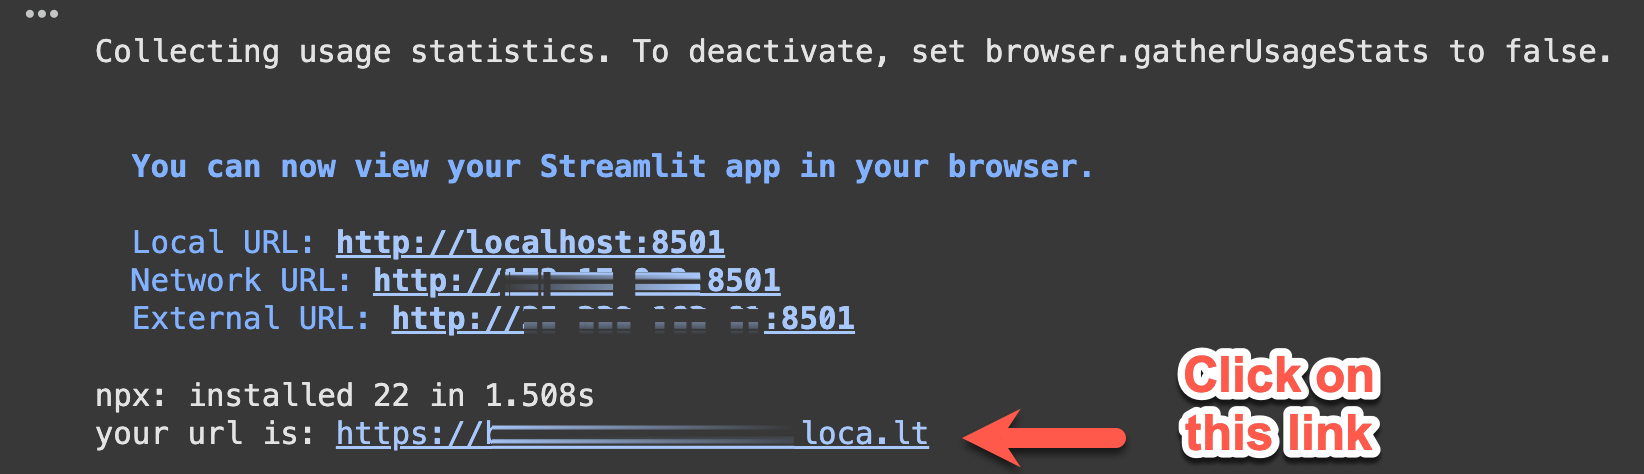

In [15]:
!streamlit run ./home-search-ai.py & npx localtunnel --port 8501



⠙⠹
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.0.3.45:8501
  External URL: http://135.237.130.231:8501

⠸⠼⠴Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 15lLRWhJj3KXtw1wWqxXjT9BYvftrB83KQ5t1bj9zGe3ROD1s4dHJQQJ99BDACYeBjFXJ3w3AAABACOGB99E
https://msbuild-demo-a54066.es.eastus.azure.elastic.cloud:443
ZzdmYmpaWUI5UkRyQnNBeUZCcnM6QV9JWkhDX1laRDlObjF1bGdidnRxUQ==
6NNp6YEyxpd7vV7mv62CgroPe1n6R3UnsOrLDasJg4qCnSHzI4EnJQQJ99BEACYeBjFkaT2IAAAgAZMP1Ox9
gpt-4o
2024-10-21
https://msbuild-demo.openai.azure.com/
15lLRWhJj3KXtw1wWqxXjT9BYvftrB83KQ5t1bj9zGe3ROD1s4dHJQQJ99BDACYeBjFXJ3w3AAABACOGB99E
https://msbuild-demo-a54066.es.eastus.azure.elastic.cloud:443
ZzdmYmpaWUI5UkRyQnNBeUZCcnM6QV9JWkhDX1laRDlObjF1bGdidnRxUQ==
6NNp6YEyxpd7vV7mv62CgroPe1n6R3UnsOrLDasJg4qCnSHzI4EnJQQJ99BEACYeBjFkaT2IAAAgAZMP1Ox9
gpt-4o
2024-10-21
https://msbuild-demo.openai.azure.com/

Formatted Messages:
Message 1:
Role: assi

## Start searching for a home...

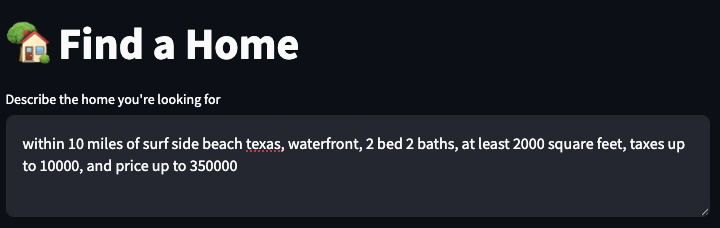

## Teardown
Deletes all data in indexes and the ML inference endpoint

In [ ]:
confirmation = input(f"Are you sure you want to delete the index and ml inference endpoint? This cannot be undone")
if confirmation.lower() != 'yes':
    print("Operation canceled.")
else:
    try:
        es.delete_script(id=TEMPLATE_ID)
        print(f"Deleted existing search template: {TEMPLATE_ID}")
    except Exception as e:
        if "not_found" in str(e):
            print(f"Search template '{TEMPLATE_ID}' not found, skipping delete.")
        else:
            print(f"Error deleting template '{TEMPLATE_ID}': {e}")
    if es.indices.exists(index=INDEX_NAME):
        es.indices.delete(index=INDEX_NAME)
        print(f"🗑️ Index '{INDEX_NAME}' deleted.")

    url = f"{ELASTIC_SERVERLESS_URL}/_inference/text_embedding/{INFERENCE_ID}"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"ApiKey {ELASTIC_SERVERLESS_API_KEY}"
    }

    # Make the DELETE request
    response = requests.delete(url, headers=headers)

    # Print the response
    if response.status_code == 200:
        print("Text embedding endpoint deleted successfully:", response.json())
    else:
        print(f"Error: {response.status_code}, {response.text}")